<a href="https://colab.research.google.com/github/MarcosGutierrez97/Msc-IA-thesis/blob/main/modelos_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import tensorflow as tf
from tensorflow import keras
import keras_cv
from keras_cv import bounding_box
from keras_cv import visualization
import pandas as pd

Using TensorFlow backend


In [ ]:
!pip install keras_cv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 613.1/613.1 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 20.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
retina = tf.keras.models.load_model('/content/drive/MyDrive/Master VIU/TFM/SKU110K_fixed/retina_model.keras')

/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/task.py:43: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/task.py:43: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


In [ ]:
yolo = tf.keras.models.load_model('/content/drive/MyDrive/Master VIU/TFM/SKU110K_fixed/yolo_model.keras')

In [ ]:
BATCH_SIZE = 4
LEARNING_RATE = 0.001
EPOCH = 5
GLOBAL_CLIPNORM = 10.0

In [ ]:
augmenter = keras.Sequential(
    layers=[
        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xyxy"),
        keras_cv.layers.RandomShear(
            x_factor=0.2, y_factor=0.2, bounding_box_format="xyxy"
        ),
        keras_cv.layers.JitteredResize(
            target_size=(1280, 1280), scale_factor=(0.8, 1.25), bounding_box_format="xyxy"
        ),
    ]
)
resizing = keras_cv.layers.Resizing(
            1280, 1280, bounding_box_format="xyxy", pad_to_aspect_ratio=True
        )
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image

def parse_tfrecord_fn(images,boxes,classes):

    image = load_image(images)

    # Create the final dictionary.
    image_dataset = {
        'images': tf.cast(image,dtype = tf.float32),
        'bounding_boxes': {
            'classes': tf.cast(classes,dtype=tf.float32),
            'boxes': tf.cast(boxes,dtype=tf.float32)
        }
    }
    return image_dataset

def dict_to_tuple(image_dataset):
    return image_dataset['images'], image_dataset['bounding_boxes']


def pre_process_info(df):
    res = {}
    for i in range(len(df)):
        xmin = ((df.iloc[i,1]))
        xmax = ((df.iloc[i,2]))
        ymin = ((df.iloc[i,3]))
        ymax = ((df.iloc[i,4]))
        labels = ((df.iloc[i,5]))
        boxes = [xmin,xmax,ymin,ymax]
        if str(df.iloc[i,0]) not in list(res.keys()):
            res[df.iloc[i,0]] = {"image_path":df.iloc[i,0], "classes":[1],"boxes":[boxes]}

        else:
            res[df.iloc[i,0]]["classes"].append(labels)
            res[df.iloc[i,0]]["boxes"].append(boxes)
    return res

In [ ]:
BASE_PATH = "/content/drive/MyDrive/Master VIU/TFM/SKU110K_fixed/"

df_test = pd.read_csv(BASE_PATH + "annotations/annotations_test.csv")
df_test["images"] = "/content/drive/MyDrive/Master VIU/TFM/SKU110K_fixed/test/" + df_test["images"]
df_test["label"] = 1
dic_test = pre_process_info(df_test)
test_dataframe = pd.DataFrame(list(dic_test.values()))
classest = tf.ragged.constant(test_dataframe["classes"])
boxest = tf.ragged.constant(test_dataframe["boxes"])
imagest = tf.ragged.constant(test_dataframe["image_path"])
ds_test = tf.data.Dataset.from_tensor_slices((imagest,boxest,classest))
test_dataset = ds_test.map(parse_tfrecord_fn)
test_ds = test_dataset.shuffle(BATCH_SIZE * 4)
test_ds = test_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
test_ds = test_ds.map(resizing, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

In [ ]:
class_mapping = {1:"Object"}

In [ ]:
dataset = next(iter(test_ds.take(1)))
def visualize_detections(model, dataset, bounding_box_format):
    images, y_true = dataset
    print(f"Images shape: {images.shape}")
    y_pred = model.predict(images)
    y_pred = bounding_box.to_ragged(y_pred)
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        scale=4,
        rows=2,
        cols=2,
        show=True,
        font_scale=0.7,
        class_mapping=class_mapping,
    )

Images shape: (4, 1280, 1280, 3)
1/1 [==============================] - 1s 620ms/step


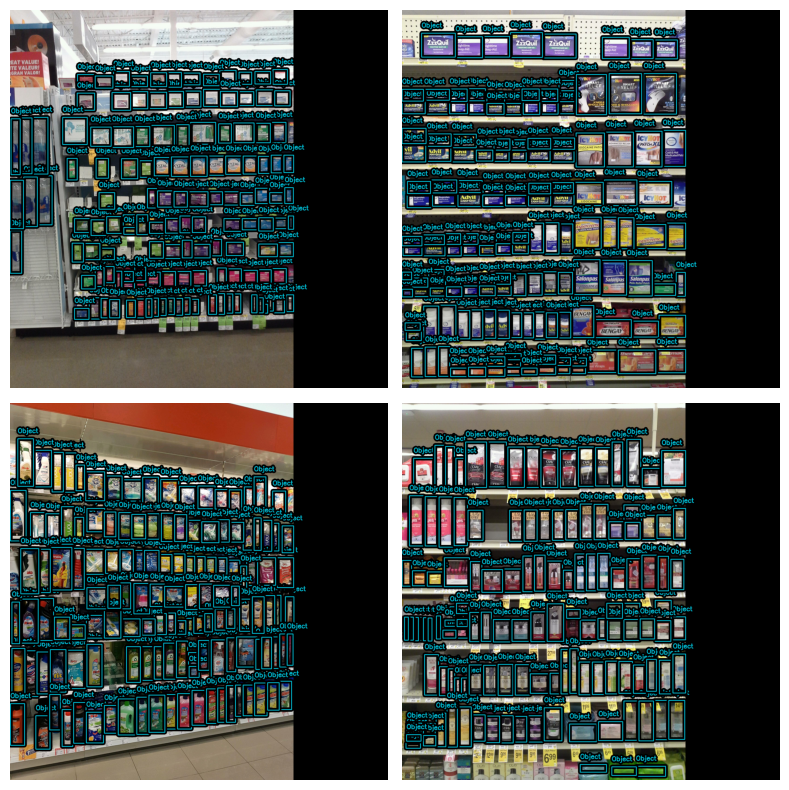

In [ ]:
visualize_detections(yolo, dataset=dataset, bounding_box_format="xyxy")

Images shape: (4, 1280, 1280, 3)
1/1 [==============================] - 35s 35s/step


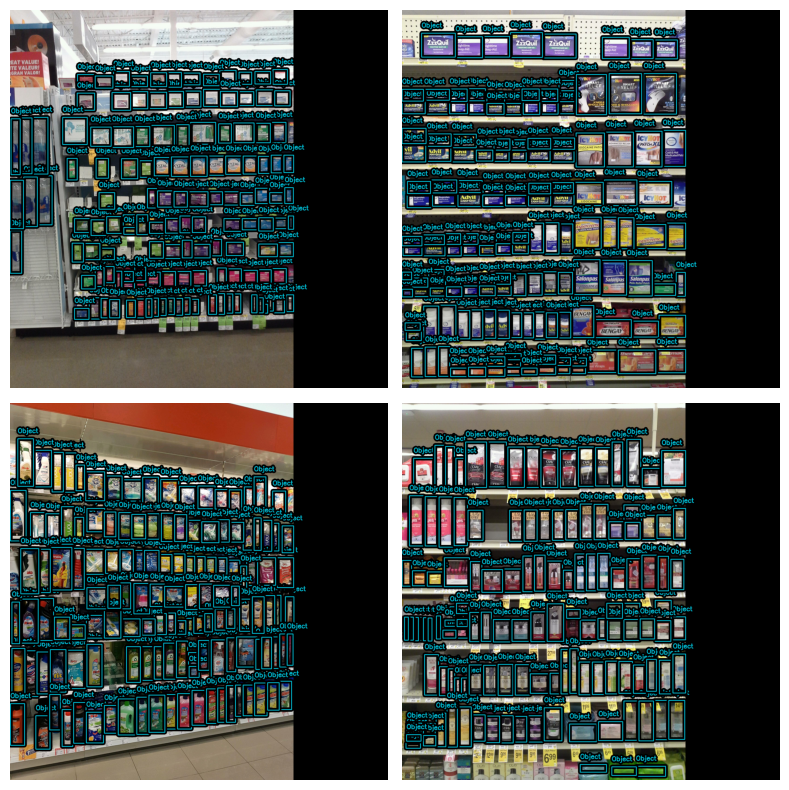

In [ ]:
visualize_detections(retina, dataset=dataset, bounding_box_format="xyxy")